# **Forecast for 5 top renewable energy producing countries**

## <font color='blue'>1. India</font>

1/1 [==============================] - 0s 18ms/step
Forecasted Renewable Energy production for future years:
Year: 2022, Production: 345.77435302734375
Year: 2023, Production: 390.128173828125
Year: 2024, Production: 439.890625
Year: 2025, Production: 496.54052734375
Year: 2026, Production: 558.947265625
Year: 2027, Production: 637.4160766601562
Year: 2028, Production: 728.5076293945312
Year: 2029, Production: 828.1415405273438
Year: 2030, Production: 933.1162109375
Year: 2031, Production: 1038.1907958984375
Year: 2032, Production: 1137.648193359375
Year: 2033, Production: 1224.583251953125


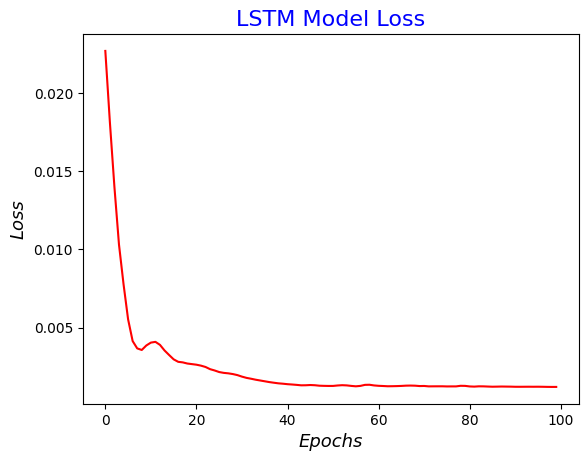

1/1 [==============================] - 0s 15ms/step


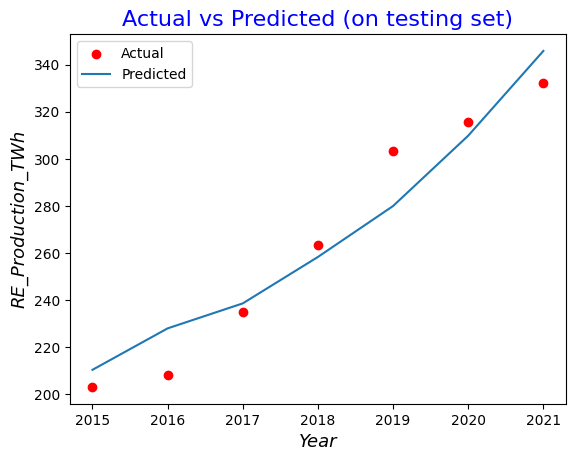

Evaluation Metrics on testing set:
Mean Absolute Error (MAE): 11.25953534807478
Root Mean Squared Error (RMSE): 13.338721686341758
Normalized Root Mean Squared Error (NRMSE): 0.04261164005476076
2/2 [==============================] - 0s 2ms/step


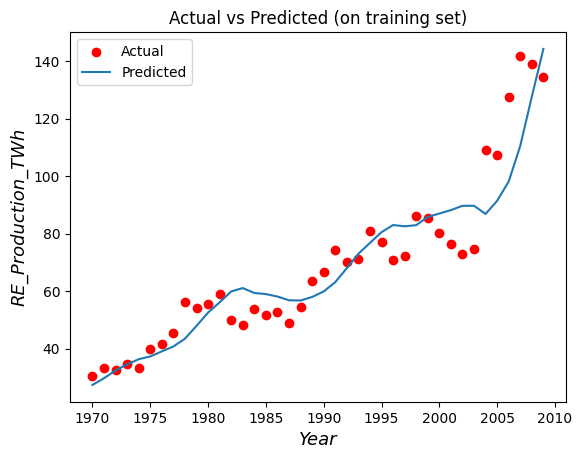

Evaluation Metrics on training set:
Mean Squared Error:119.0059274535791
Root Mean Squared Error:10.908983795641971
Normalized Root Mean Squared Error:0.03484964315126976


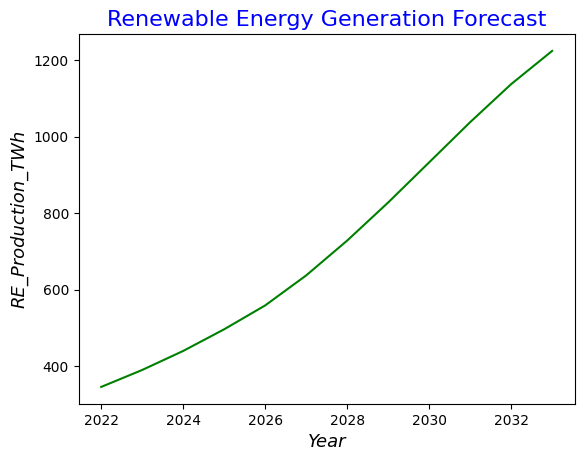

     Years  Renewable_Energy_Production_TWh
0   2022.0                       345.774353
1   2023.0                       390.128174
2   2024.0                       439.890625
3   2025.0                       496.540527
4   2026.0                       558.947266
5   2027.0                       637.416077
6   2028.0                       728.507629
7   2029.0                       828.141541
8   2030.0                       933.116211
9   2031.0                      1038.190796
10  2032.0                      1137.648193
11  2033.0                      1224.583252


In [37]:
#LSTM attempt 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Load the dataset
data = pd.read_csv("C:/Users/Hp/OneDrive/Desktop/UST-Intern/Energy/Data Used for forecasting/India_data.csv")

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['total_RE_generated_TWh'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the training data
lookback = 5  # Number of previous time steps to consider
X_train, y_train = [], []
for i in range(len(train_data) - lookback):
    X_train.append(train_data[i:i + lookback, 0])
    y_train.append(train_data[i + lookback, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50,input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam())

# Set up early stopping
early_stopping = EarlyStopping(patience=10, verbose=1)

# Train the model
history=model.fit(X_train, y_train,epochs=100, batch_size=32, verbose=0)

# Prepare the testing data
X_test, y_test = [], []
for i in range(len(test_data) - lookback):
    X_test.append(test_data[i:i + lookback, 0])
    y_test.append(test_data[i + lookback, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test=scaler.inverse_transform(y_test.reshape(-1,1))






# Print the forecasted production for future years
future_years = 12  # Number of future years to forecast
last_sequence = X_test[-1]  # Last sequence from the test set
forecasted_production = []
for _ in range(future_years):
    input_data = np.reshape(last_sequence, (1, lookback, 1))
    prediction = model.predict(input_data)
    forecasted_production.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = prediction

# Scale the forecasted production back to the original range
forecasted_production = scaler.inverse_transform(np.array(forecasted_production).reshape(-1, 1))

# Print the forecasted production for future years
print("Forecasted Renewable Energy production for future years:")
for i in range(future_years):
    year = data['year'].max() + i + 1
    production = forecasted_production[i, 0]
    print(f"Year: {year}, Production: {production}")
    
    
# Plot of loss history (loss vs epochs)
plt.plot(history.history['loss'],'r-')
plt.title('LSTM Model Loss', fontsize=16,color='blue')
plt.xlabel('Epochs',fontstyle='italic',fontsize=13)
plt.ylabel('Loss',fontstyle='italic',fontsize=13)
plt.savefig('model_loss_india.png')
plt.show()
    
# Make predictions on testing set
alpha = model.predict(X_test)
predictions = scaler.inverse_transform(alpha)

# Plot of actual vs predicted (on testing set)
Ytest=Y_test.tolist()
flattend_list=[value[0] for value in Ytest]
filtered_values = data.query("total_RE_generated_TWh in @flattend_list")['year']
year_values=np.array(filtered_values)
plt.scatter(year_values,Y_test,label='Actual',color='r')
plt.plot(year_values,predictions, label='Predicted')
plt.title('Actual vs Predicted (on testing set)',fontsize=16,color='blue')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.legend()
plt.savefig('actual_vs_predicted_testing_india.png')
plt.show()

#Evaluation Metrics on testing set
mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
nrmse = rmse / (np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print("Evaluation Metrics on testing set:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized Root Mean Squared Error (NRMSE): {nrmse}")

#Make predictions on training set
bot=model.predict(X_train)
pred_tr=scaler.inverse_transform(bot)

#Plot of Actual vs Predicted (on training set)
ytrain=convert_array_to_float(scaler.inverse_transform(y_train.reshape(-1,1)))
Ytrain=np.array(ytrain)
filter_values = data.query("total_RE_generated_TWh in @ytrain")['year']
year_value=np.array(filter_values)
plt.scatter(year_value,Ytrain,label='Actual',color='r')
plt.plot(year_value,pred_tr,label='Predicted')
plt.title('Actual vs Predicted (on training set)')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.legend()
plt.savefig('actual_vs_predicted_training_india.png')
plt.show()

#Evaluation metrics on training set
mse=mean_squared_error(pred_tr,ytrain)
rmse=np.sqrt(mse)
nrmse=rmse/(np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print(f'Evaluation Metrics on training set:\nMean Squared Error:{mse}\nRoot Mean Squared Error:{rmse}\nNormalized Root Mean Squared Error:{nrmse}')
    
#PLot of forecast vs years
Year=np.ones((future_years,1))
for i in range(future_years):
    Year[i]=data['year'].max() + i + 1
plt.plot(Year,forecasted_production,'g-')
plt.title('Renewable Energy Generation Forecast',fontsize=16,color='blue')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.savefig('forecast_india.png')
plt.show()

#download forecast
Years=Year.tolist()
years=[value[0] for value in Years]
RE_production=forecasted_production.tolist()
RE_Production=[value[0] for value in RE_production]
final_forecast_data=pd.DataFrame({'Years':years,'Renewable_Energy_Production_TWh':RE_Production})
print(final_forecast_data)
final_forecast_data.to_csv('final_forecast_india.csv',index=False)

## <font color='blue'>2. China</font>

1/1 [==============================] - 0s 109ms/step
Forecasted Renewable Energy production for future years:
Year: 2022, Production: 2512.207763671875
Year: 2023, Production: 2789.513671875
Year: 2024, Production: 3122.26611328125
Year: 2025, Production: 3487.9287109375
Year: 2026, Production: 3925.55908203125
Year: 2027, Production: 4414.90234375
Year: 2028, Production: 4975.15576171875
Year: 2029, Production: 5617.33056640625
Year: 2030, Production: 6359.67578125
Year: 2031, Production: 7216.46484375
Year: 2032, Production: 8208.255859375
Year: 2033, Production: 9358.8330078125


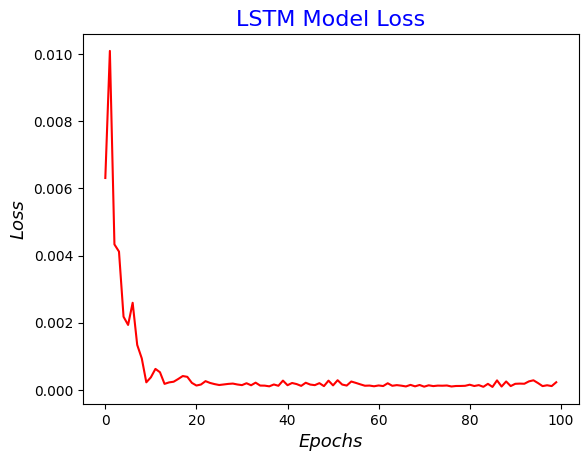

1/1 [==============================] - 0s 158ms/step


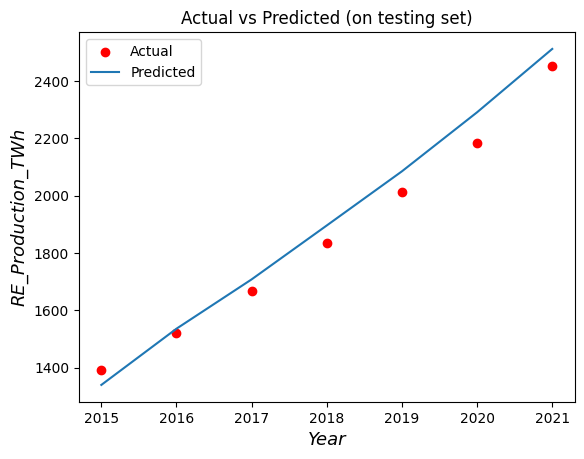

Evaluation Metrics on testing set:
Mean Absolute Error (MAE): 58.02891601562494
Root Mean Squared Error (RMSE): 63.650588533819864
Normalized Root Mean Squared Error (NRMSE): 0.02615974704963519
2/2 [==============================] - 0s 141ms/step


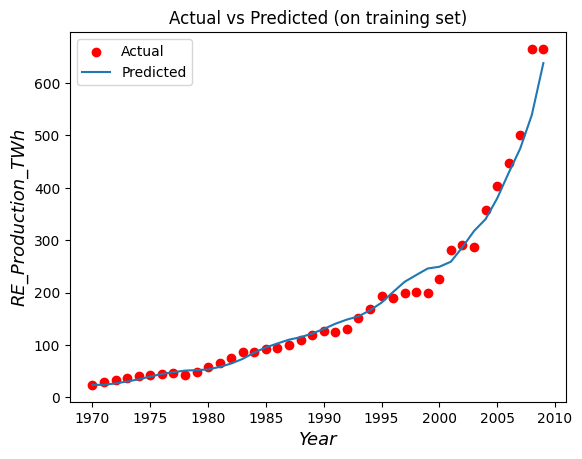

Evaluation Metrics on training set:
Mean Squared Error:645.3854401778638
Root Mean Squared Error:25.404437411166256
Normalized Root Mean Squared Error:0.010440966406167419


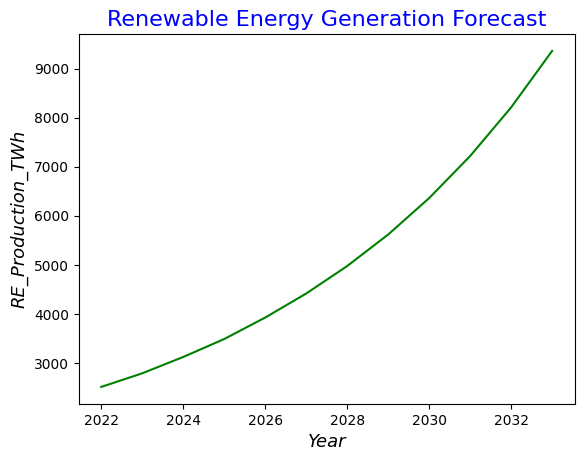

     Years  Renewable_Energy_Production_TWh
0   2022.0                      2512.207764
1   2023.0                      2789.513672
2   2024.0                      3122.266113
3   2025.0                      3487.928711
4   2026.0                      3925.559082
5   2027.0                      4414.902344
6   2028.0                      4975.155762
7   2029.0                      5617.330566
8   2030.0                      6359.675781
9   2031.0                      7216.464844
10  2032.0                      8208.255859
11  2033.0                      9358.833008


In [21]:
#LSTM attempt 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Load the dataset
data = pd.read_csv("C:/Users/Hp/OneDrive/Desktop/UST-Intern/Energy/Data Used for forecasting/China_data.csv")

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['total_RE_generated_TWh'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the training data
lookback = 5  # Number of previous time steps to consider
X_train, y_train = [], []
for i in range(len(train_data) - lookback):
    X_train.append(train_data[i:i + lookback, 0])
    y_train.append(train_data[i + lookback, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(4000,input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam())

# Set up early stopping
early_stopping = EarlyStopping(patience=10, verbose=1)

# Train the model
history=model.fit(X_train, y_train,epochs=100, batch_size=32, verbose=0)

# Prepare the testing data
X_test, y_test = [], []
for i in range(len(test_data) - lookback):
    X_test.append(test_data[i:i + lookback, 0])
    y_test.append(test_data[i + lookback, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test=scaler.inverse_transform(y_test.reshape(-1,1))


# Print the forecasted production for future years
future_years = 12  # Number of future years to forecast
last_sequence = X_test[-1]  # Last sequence from the test set
forecasted_production = []
for _ in range(future_years):
    input_data = np.reshape(last_sequence, (1, lookback, 1))
    prediction = model.predict(input_data)
    forecasted_production.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = prediction

# Scale the forecasted production back to the original range
forecasted_production = scaler.inverse_transform(np.array(forecasted_production).reshape(-1, 1))

# Print the forecasted production for future years
print("Forecasted Renewable Energy production for future years:")
for i in range(future_years):
    year = data['year'].max() + i + 1
    production = forecasted_production[i, 0]
    print(f"Year: {year}, Production: {production}")
    
    
# Plot of loss history (loss vs epochs)
plt.plot(history.history['loss'],'r-')
plt.title('LSTM Model Loss', fontsize=16,color='blue')
plt.xlabel('Epochs',fontstyle='italic',fontsize=13)
plt.ylabel('Loss',fontstyle='italic',fontsize=13)
plt.savefig('model_loss_china.png')
plt.show()
    
# Make predictions on the testing set
alpha = model.predict(X_test)
predictions = scaler.inverse_transform(alpha)

#Plot of Actual vs Predicted (on testing set)
ytest=convert_array_to_float(Y_test)
filtered_values = data.query("total_RE_generated_TWh in @ytest")['year']
year_values=np.array(filtered_values)

plt.scatter(year_values,ytest,label='Actual',color='r')
plt.plot(year_values,predictions,label='Predicted')
plt.title('Actual vs Predicted (on testing set)')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.legend()
plt.savefig('actual_vs_predicted_testing_china.png')
plt.show()

# Evaluation metrics on testing set
mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
nrmse = rmse / (np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print("Evaluation Metrics on testing set:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized Root Mean Squared Error (NRMSE): {nrmse}")


#Make predictions on training set
bot=model.predict(X_train)
pred_tr=scaler.inverse_transform(bot)

#Plot of Actual vs Predicted (on training set)
ytrain=convert_array_to_float(scaler.inverse_transform(y_train.reshape(-1,1)))
Ytrain=np.array(ytrain)
filter_values = data.query("total_RE_generated_TWh in @ytrain")['year']
year_value=np.array(filter_values)
plt.scatter(year_value,Ytrain,label='Actual',color='r')
plt.plot(year_value,pred_tr,label='Predicted')
plt.title('Actual vs Predicted (on training set)')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.legend()
plt.savefig('actual_vs_predicted_training_china.png')
plt.show()

#Evaluation metrics on training set
mse=mean_squared_error(pred_tr,ytrain)
rmse=np.sqrt(mse)
nrmse=rmse/(np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print(f'Evaluation Metrics on training set:\nMean Squared Error:{mse}\nRoot Mean Squared Error:{rmse}\nNormalized Root Mean Squared Error:{nrmse}')


#PLot of forecast vs years
Year=np.ones((future_years,1))
for i in range(future_years):
    Year[i]=data['year'].max() + i + 1
plt.plot(Year,forecasted_production,'g-')
plt.title('Renewable Energy Generation Forecast',fontsize=16,color='blue')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.savefig('forecast_china.png')
plt.show()

    
#download forecast
Years=Year.tolist()
years=[value[0] for value in Years]
RE_production=forecasted_production.tolist()
RE_Production=[value[0] for value in RE_production]
final_forecast_data=pd.DataFrame({'Years':years,'Renewable_Energy_Production_TWh':RE_Production})
print(final_forecast_data)
final_forecast_data.to_csv('final_forecast_china.csv',index=False)

## <font color='blue'>3. Brazil</font>

1/1 [==============================] - 0s 20ms/step
Forecasted Renewable Energy production for future years:
Year: 2022, Production: 518.7693481445312
Year: 2023, Production: 532.066162109375
Year: 2024, Production: 544.3567504882812
Year: 2025, Production: 553.0234375
Year: 2026, Production: 560.4946899414062
Year: 2027, Production: 568.6863403320312
Year: 2028, Production: 578.7385864257812
Year: 2029, Production: 587.7967529296875
Year: 2030, Production: 596.4005126953125
Year: 2031, Production: 605.1486206054688
Year: 2032, Production: 614.1132202148438
Year: 2033, Production: 623.1201171875


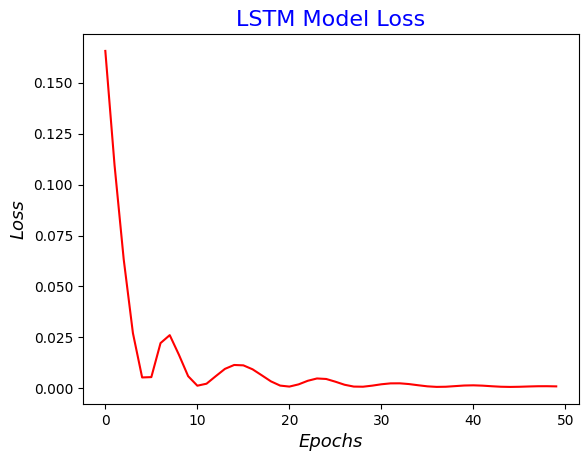

1/1 [==============================] - 0s 26ms/step


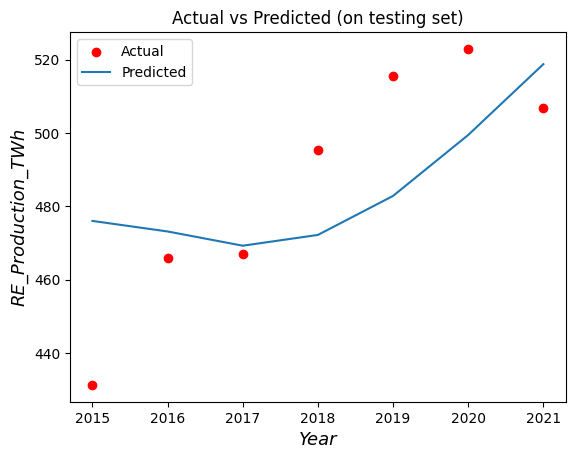

Evaluation Metrics on testing set:
Mean Absolute Error (MAE): 20.768124128069196
Root Mean Squared Error (RMSE): 24.918275065434376
Normalized Root Mean Squared Error (NRMSE): 0.05009705481591149
2/2 [==============================] - 0s 6ms/step


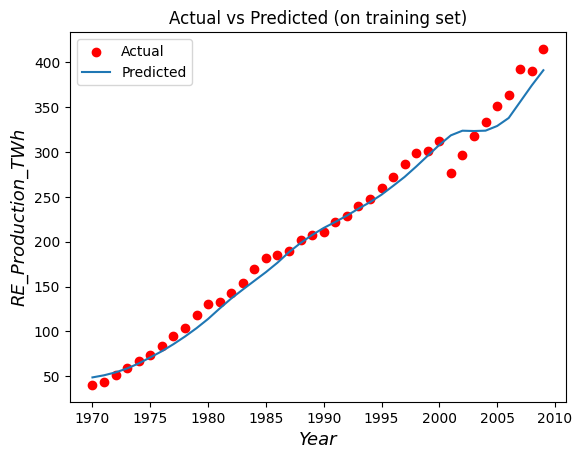

Evaluation Metrics on training set:
Mean Squared Error:202.8413449142988
Root Mean Squared Error:14.242238058475879
Normalized Root Mean Squared Error:0.028633369639074948


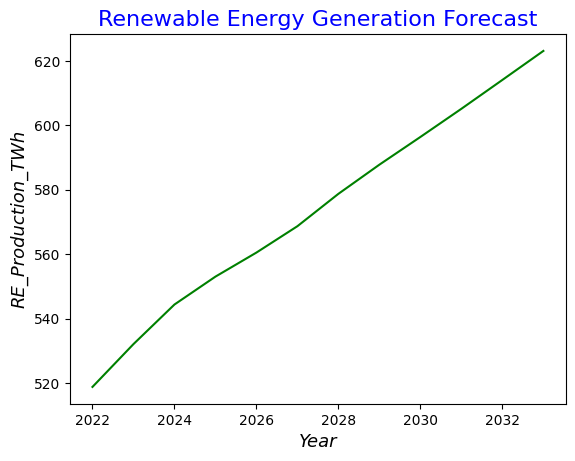

     Years  Renewable_Energy_Production_TWh
0   2022.0                       518.769348
1   2023.0                       532.066162
2   2024.0                       544.356750
3   2025.0                       553.023438
4   2026.0                       560.494690
5   2027.0                       568.686340
6   2028.0                       578.738586
7   2029.0                       587.796753
8   2030.0                       596.400513
9   2031.0                       605.148621
10  2032.0                       614.113220
11  2033.0                       623.120117


In [66]:
#LSTM attempt 3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Load the dataset
data = pd.read_csv("C:/Users/Hp/OneDrive/Desktop/UST-Intern/Energy/Data Used for forecasting/Brazil_data.csv")

# Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['total_RE_generated_TWh'].values.reshape(-1, 1))

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the training data
lookback = 5  # Number of previous time steps to consider
X_train, y_train = [], []
for i in range(len(train_data) - lookback):
    X_train.append(train_data[i:i + lookback, 0])
    y_train.append(train_data[i + lookback, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(500,input_shape=(lookback, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam())

# Set up early stopping
early_stopping = EarlyStopping(patience=10, verbose=1)

# Train the model
history=model.fit(X_train, y_train,epochs=50, batch_size=128, verbose=0)

# Prepare the testing data
X_test, y_test = [], []
for i in range(len(test_data) - lookback):
    X_test.append(test_data[i:i + lookback, 0])
    y_test.append(test_data[i + lookback, 0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
Y_test=scaler.inverse_transform(y_test.reshape(-1,1))


# Print the forecasted production for future years
future_years = 12  # Number of future years to forecast
last_sequence = X_test[-1]  # Last sequence from the test set
forecasted_production = []
for _ in range(future_years):
    input_data = np.reshape(last_sequence, (1, lookback, 1))
    prediction = model.predict(input_data)
    forecasted_production.append(prediction[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = prediction

# Scale the forecasted production back to the original range
forecasted_production = scaler.inverse_transform(np.array(forecasted_production).reshape(-1, 1))

# Print the forecasted production for future years
print("Forecasted Renewable Energy production for future years:")
for i in range(future_years):
    year = data['year'].max() + i + 1
    production = forecasted_production[i, 0]
    print(f"Year: {year}, Production: {production}")
    
    
# Plot of loss history (loss vs epochs)
plt.plot(history.history['loss'],'r-')
plt.title('LSTM Model Loss', fontsize=16,color='blue')
plt.xlabel('Epochs',fontstyle='italic',fontsize=13)
plt.ylabel('Loss',fontstyle='italic',fontsize=13)
plt.savefig('model_loss_brazil.png')
plt.show()
    
# Make predictions on the testing set
alpha = model.predict(X_test)
predictions = scaler.inverse_transform(alpha)

#Plot of Actual vs Predicted (on testing set)
ytest=convert_array_to_float(Y_test)
filtered_values = data.query("total_RE_generated_TWh in @ytest")['year']
year_values=np.array(filtered_values)

plt.scatter(year_values,ytest,label='Actual',color='r')
plt.plot(year_values,predictions,label='Predicted')
plt.title('Actual vs Predicted (on testing set)')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.legend()
plt.savefig('actual_vs_predicted_testing_brazil.png')
plt.show()

# Evaluation metrics on testing set
mae = mean_absolute_error(Y_test, predictions)
rmse = np.sqrt(mean_squared_error(Y_test, predictions))
nrmse = rmse / (np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print("Evaluation Metrics on testing set:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized Root Mean Squared Error (NRMSE): {nrmse}")


#Make predictions on training set
bot=model.predict(X_train)
pred_tr=scaler.inverse_transform(bot)

#Plot of Actual vs Predicted (on training set)
ytrain=convert_array_to_float(scaler.inverse_transform(y_train.reshape(-1,1)))
Ytrain=np.array(ytrain)
filter_values = data.query("total_RE_generated_TWh in @ytrain")['year']
year_value=np.array(filter_values)
plt.scatter(year_value,Ytrain,label='Actual',color='r')
plt.plot(year_value,pred_tr,label='Predicted')
plt.title('Actual vs Predicted (on training set)')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.legend()
plt.savefig('actual_vs_predicted_training_brazil.png')
plt.show()

#Evaluation metrics on training set
mse=mean_squared_error(pred_tr,ytrain)
rmse=np.sqrt(mse)
nrmse=rmse/(np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print(f'Evaluation Metrics on training set:\nMean Squared Error:{mse}\nRoot Mean Squared Error:{rmse}\nNormalized Root Mean Squared Error:{nrmse}')


#PLot of forecast vs years
Year=np.ones((future_years,1))
for i in range(future_years):
    Year[i]=data['year'].max() + i + 1
plt.plot(Year,forecasted_production,'g-')
plt.title('Renewable Energy Generation Forecast',fontsize=16,color='blue')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.savefig('forecast_brazil.png')
plt.show()

    
#download forecast
Years=Year.tolist()
years=[value[0] for value in Years]
RE_production=forecasted_production.tolist()
RE_Production=[value[0] for value in RE_production]
final_forecast_data=pd.DataFrame({'Years':years,'Renewable_Energy_Production_TWh':RE_Production})
print(final_forecast_data)
final_forecast_data.to_csv('final_forecast_brazil.csv',index=False)

## <font color='blue'>4. United States</font>

Mean Squared Error (MSE): 1076.7848383617659
Root Mean Squared Error (RMSE): 32.81439986289199
Normalized Root Mean Squared Error (RMSE): 0.04898914629516742


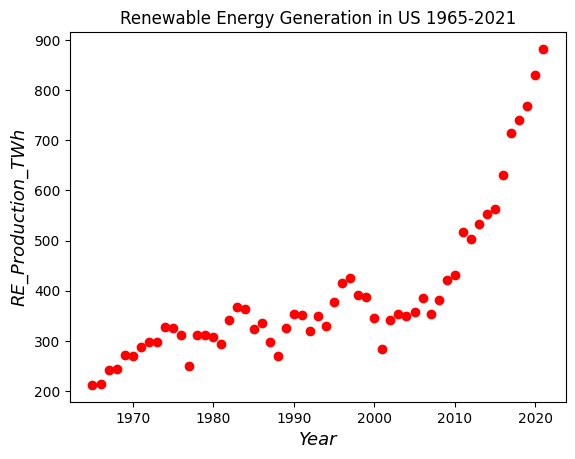

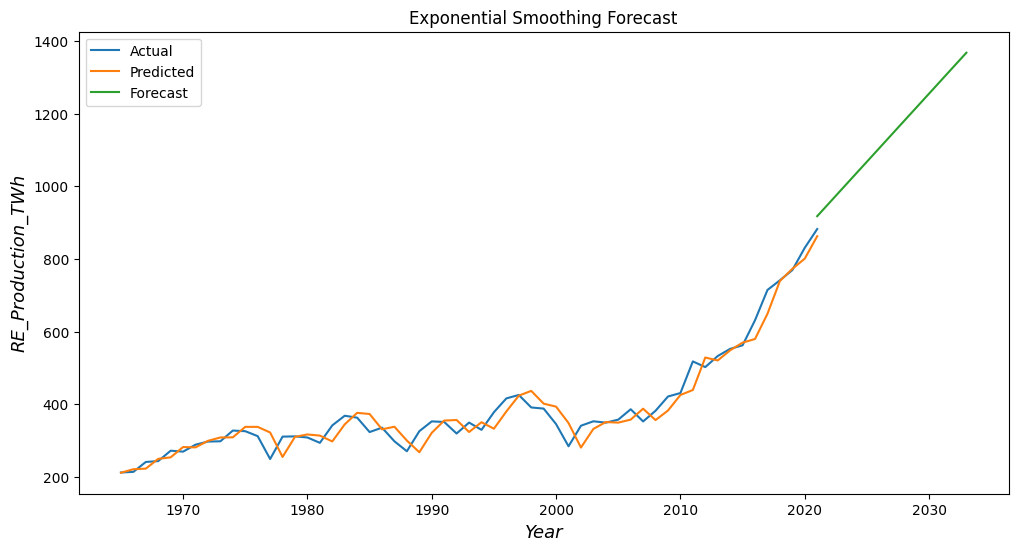

Year: 2021, Forecasted Production: 917.5781715942602
Year: 2022, Forecasted Production: 955.0608034269064
Year: 2023, Forecasted Production: 992.5434352595527
Year: 2024, Forecasted Production: 1030.026067092199
Year: 2025, Forecasted Production: 1067.5086989248452
Year: 2026, Forecasted Production: 1104.9913307574914
Year: 2027, Forecasted Production: 1142.4739625901377
Year: 2028, Forecasted Production: 1179.9565944227838
Year: 2029, Forecasted Production: 1217.4392262554302
Year: 2030, Forecasted Production: 1254.9218580880765
Year: 2031, Forecasted Production: 1292.4044899207227
Year: 2032, Forecasted Production: 1329.887121753369
Year: 2033, Forecasted Production: 1367.3697535860151


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load the time series data
data = pd.read_csv("C:/Users/Hp/OneDrive/Desktop/UST-Intern/Energy/Data Used for forecasting/US_data.csv")

# Extract the relevant columns (years and production)
years = data['year']
production = data['total_RE_generated_TWh']

# Create the training data
train_data = pd.DataFrame({'year': years, 'total_RE_generated_TWh': production})

# Set the frequency of the time series (in this case, yearly)
train_data['year'] = pd.to_datetime(train_data['year'], format='%Y')
train_data = train_data.set_index('year')
train_data = train_data.asfreq('YS')

# Build and fit the Exponential Smoothing model
model = ExponentialSmoothing(train_data['total_RE_generated_TWh'], trend='add', seasonal=None)
fitted_model = model.fit()

# Generate forecasts for the future years
future_years = pd.date_range(start=train_data.index[-1], periods=13, freq='AS')
forecast = fitted_model.forecast(len(future_years))

# Evaluate the model on the training data
train_predictions = fitted_model.fittedvalues
mse = mean_squared_error(train_data['total_RE_generated_TWh'], train_predictions)
rmse = np.sqrt(mse)
nrmse=rmse/(np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized Root Mean Squared Error (RMSE): {nrmse}")

# Plot the original data
plt.scatter(years,production,color='r')
plt.title('Renewable Energy Generation in US 1965-2021')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.savefig('us_data.png')
plt.show()

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['total_RE_generated_TWh'], label='Actual')
plt.plot(train_predictions.index, train_predictions, label='Predicted')
plt.plot(future_years, forecast, label='Forecast')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.savefig('forecast_us.png')
plt.show()

# Print the forecasted production for future years
for year, value in zip(future_years.year, forecast):
    print(f"Year: {year}, Forecasted Production: {value}")

years=np.array([2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033])
df=pd.DataFrame({'Year':years,'RE_Production_TWh':np.array(forecast)})
df=df.drop(0)
df.to_csv('final_forecast_us.csv',index=False)

## <font color='blue'>5. Canada</font>

Mean Squared Error (MSE): 115.8275562270894
Root Mean Squared Error (RMSE): 10.762321135660718
Normalized Root Mean Squared Error (RMSE): 0.03337774821877162


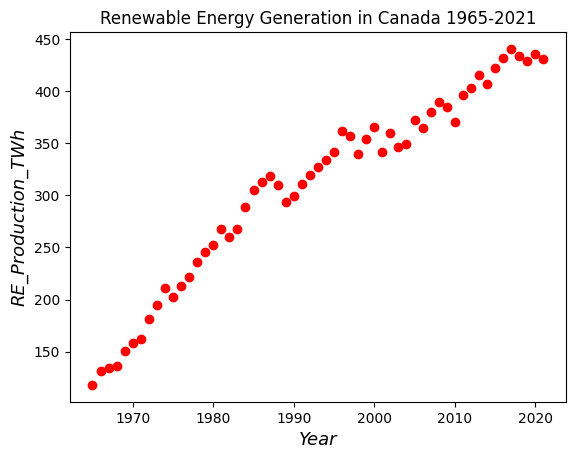

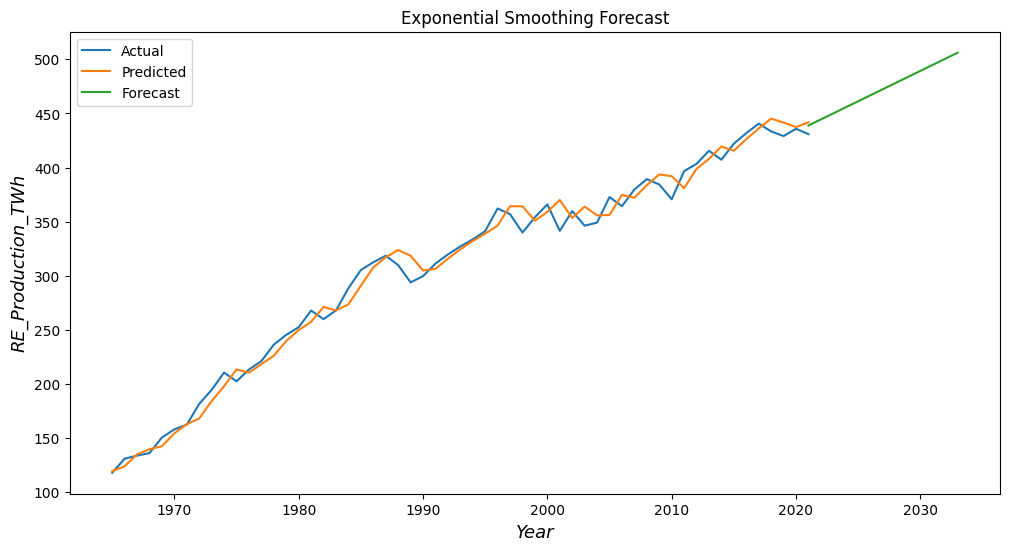

Year: 2021, Forecasted Production: 438.8332941727856
Year: 2022, Forecasted Production: 444.4349229170643
Year: 2023, Forecasted Production: 450.036551661343
Year: 2024, Forecasted Production: 455.63818040562177
Year: 2025, Forecasted Production: 461.23980914990045
Year: 2026, Forecasted Production: 466.8414378941792
Year: 2027, Forecasted Production: 472.44306663845794
Year: 2028, Forecasted Production: 478.0446953827367
Year: 2029, Forecasted Production: 483.64632412701536
Year: 2030, Forecasted Production: 489.2479528712941
Year: 2031, Forecasted Production: 494.84958161557284
Year: 2032, Forecasted Production: 500.45121035985153
Year: 2033, Forecasted Production: 506.05283910413027


In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

# Load the time series data
data = pd.read_csv("C:/Users/Hp/OneDrive/Desktop/UST-Intern/Energy/Data Used for forecasting/Canada_data.csv")

# Extract the relevant columns (years and production)
years = data['year']
production = data['total_RE_generated_TWh']

# Create the training data
train_data = pd.DataFrame({'year': years, 'total_RE_generated_TWh': production})

# Set the frequency of the time series (in this case, yearly)
train_data['year'] = pd.to_datetime(train_data['year'], format='%Y')
train_data = train_data.set_index('year')
train_data = train_data.asfreq('YS')

# Build and fit the Exponential Smoothing model
model = ExponentialSmoothing(train_data['total_RE_generated_TWh'], trend='add', seasonal=None)
fitted_model = model.fit()

# Generate forecasts for the future years
future_years = pd.date_range(start=train_data.index[-1], periods=13, freq='AS')
forecast = fitted_model.forecast(len(future_years))

# Evaluate the model on the training data
train_predictions = fitted_model.fittedvalues
mse = mean_squared_error(train_data['total_RE_generated_TWh'], train_predictions)
rmse = np.sqrt(mse)
nrmse=rmse/(np.max(data['total_RE_generated_TWh']) - np.min(data['total_RE_generated_TWh']))
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Normalized Root Mean Squared Error (RMSE): {nrmse}")

# Plot the original data
plt.scatter(years,production,color='r')
plt.title('Renewable Energy Generation in Canada 1965-2021')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.savefig('canada_data.png')
plt.show()

# Plot the predicted and actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['total_RE_generated_TWh'], label='Actual')
plt.plot(train_predictions.index, train_predictions, label='Predicted')
plt.plot(future_years, forecast, label='Forecast')
plt.xlabel('Year',fontstyle='italic',fontsize=13)
plt.ylabel('RE_Production_TWh',fontstyle='italic',fontsize=13)
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.savefig('forecast_canada.png')
plt.show()

# Print the forecasted production for future years
for year, value in zip(future_years.year, forecast):
    print(f"Year: {year}, Forecasted Production: {value}")

years=np.array([2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033])
df=pd.DataFrame({'Year':years,'RE_Production_TWh':np.array(forecast)})
df=df.drop(0)
df.to_csv('final_forecast_canada.csv',index=False)

In [1]:
# import numpy as np
def convert_array_to_float(arr):
    # Create an empty list to store the converted elements
    converted_arr = []

    # Iterate over each element in the array
    for element in arr:
        # Convert the element to float and round off to 2 decimal places
        converted_element = round(float(element), 2)
        # Append the converted element to the new list
        converted_arr.append(converted_element)

    return converted_arr
